In [1]:
import os
import polars as pl
import duckdb
import time
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from helpers import track_memory_and_time, plot_results

In [2]:
base_path = "leash-BELKA"

# Benchmark 2: filtering, grouping, and sorting

In [3]:
def benchmark_polars(file_path, min_count=15):
    start_time = time.time()

    if "parquet" in file_path:
        lazy_df = pl.scan_parquet(file_path)
    else:
        lazy_df = pl.scan_csv(file_path)

    # Perform filtering, grouping, and counting
    result = (
        lazy_df.filter(pl.col("binds") == 1)
        .group_by("protein_name")
        .agg([pl.count()])
        .filter(pl.col("count") >= min_count)
        .sort("count", descending=True)
        .collect()
    )

    elapsed_time = time.time() - start_time
    return elapsed_time, result.head(10)


def benchmark_duckdb(file_path, min_count=15):
    start_time = time.time()

    con = duckdb.connect()

    # Query using DuckDB for filtering, grouping, and sorting
    if "parquet" in file_path:
        result = con.execute(
            f"""
            SELECT protein_name, COUNT(*) as count
            FROM parquet_scan('{file_path}')
            WHERE binds=0
            GROUP BY protein_name
            HAVING count >= {min_count}
            ORDER BY count DESC
        """
        ).df()
    else:
        result = con.execute(
            f"""
            SELECT protein_name, COUNT(*) as count
            FROM read_csv_auto('{file_path}')
            WHERE binds=0
            GROUP BY protein_name
            HAVING count >= {min_count}
            ORDER BY count DESC
        """
        ).df()

    elapsed_time = time.time() - start_time
    return elapsed_time, result.head(10)

In [7]:
runtime, mem, result = benchmark_polars(
    os.path.join(base_path, "train.parquet"), min_count=15
)
print("Time:", runtime)
print("RAM:", mem)
print(result)

C:\Users\predator\AppData\Local\Temp\ipykernel_388\718349188.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg([pl.count()])


Time: 0.7190678119659424
RAM: 252.63671875
shape: (3, 2)
┌──────────────┬────────┐
│ protein_name ┆ count  │
│ ---          ┆ ---    │
│ str          ┆ u32    │
╞══════════════╪════════╡
│ sEH          ┆ 724532 │
│ BRD4         ┆ 456964 │
│ HSA          ┆ 408410 │
└──────────────┴────────┘


In [8]:
runtime, mem, result = benchmark_duckdb(
    os.path.join(base_path, "train.parquet"), min_count=15
)
print("Time:", runtime)
print("RAM:", mem)
print(result)

Time: 0.8714523315429688
RAM: 10.65234375
  protein_name     count
0          HSA  98007200
1         BRD4  97958646
2          sEH  97691078


# Start benchmark

In [4]:
### Run the benchmarks multiple times and store results ###
def run_benchmarks(file_path, n_runs=5, is_polar=True):
    results = []
    for i in tqdm(range(n_runs)):
        if is_polar:
            # Run Polars benchmark
            runtime, mem, result = track_memory_and_time(benchmark_polars, file_path)

            # Store the times in a list for each run
            results.append(
                {
                    "Run": i + 1,
                    "Polars Time": runtime,
                    "Polars Memory (MB)": mem,
                }
            )
        else:
            # Run DuckDB benchmark
            runtime, mem, result = track_memory_and_time(benchmark_duckdb, file_path)

            # Store the times in a list for each run
            results.append(
                {
                    "Run": i + 1,
                    "DuckDB Time": runtime,
                    "DuckDB Memory (MB)": mem,
                }
            )

        # wait for release memory
        time.sleep(5)

    return results

## Parquet benchmark

In [5]:
# Run the benchmarks
results_db = run_benchmarks(
    os.path.join(base_path, "train.parquet"), n_runs=20, is_polar=False
)

# Convert the results to a DataFrame
df_results_db = pd.DataFrame(results_db)

100%|██████████| 20/20 [02:07<00:00,  6.38s/it]


In [6]:
# Run the benchmarks
results_pl = run_benchmarks(os.path.join(base_path, "train.parquet"), n_runs=20)

# Convert the results to a DataFrame
df_results_pl = pd.DataFrame(results_pl)

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\predator\AppData\Local\Temp\ipykernel_1088\2129410663.py:13: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg([pl.count()])
100%|██████████| 20/20 [02:04<00:00,  6.25s/it]


In [7]:
df_results = df_results_pl.merge(df_results_db, on="Run")
df_results.head()

,Run,Polars Time,Polars Memory (MB),DuckDB Time,DuckDB Memory (MB)
0,1,0.809151,564.300781,0.863677,163.542969
1,2,0.704564,629.941406,0.883554,164.906250
2,3,0.668053,588.152344,0.841789,164.808594
3,4,0.694673,614.671875,0.837916,164.535156
4,5,0.704252,573.832031,0.844961,164.777344


In [8]:
df_results.to_csv("stats/benchmark2_parquet.csv", index=False)

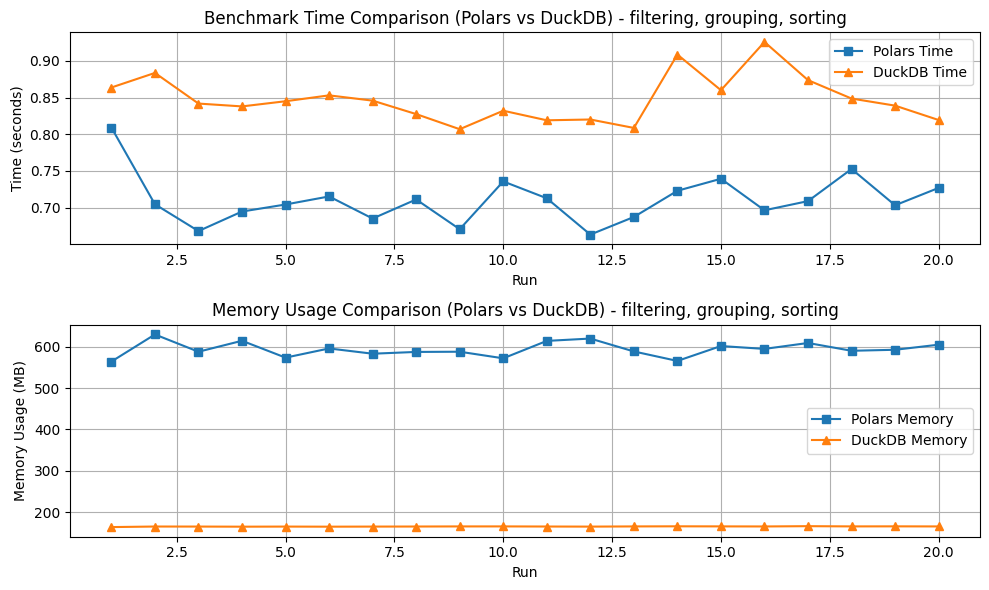

In [9]:
title1 = "Benchmark Time Comparison (Polars vs DuckDB) - filtering, grouping, sorting"
title2 = "Memory Usage Comparison (Polars vs DuckDB) - filtering, grouping, sorting"
plot_results(df_results, title1, title2)

## CSV benchmark

In [10]:
# Run the benchmarks
results_db = run_benchmarks(
    os.path.join(base_path, "train.csv"), n_runs=5, is_polar=False
)

# Convert the results to a DataFrame
df_results_db = pd.DataFrame(results_db)

100%|██████████| 5/5 [04:00<00:00, 48.13s/it]


In [11]:
# Run the benchmarks
results_pl = run_benchmarks(os.path.join(base_path, "train.csv"), n_runs=5)

# Convert the results to a DataFrame
df_results_pl = pd.DataFrame(results_pl)

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\predator\AppData\Local\Temp\ipykernel_1088\2129410663.py:13: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg([pl.count()])
100%|██████████| 5/5 [04:40<00:00, 56.10s/it]


In [12]:
df_results = df_results_pl.merge(df_results_db, on="Run")
df_results.head()

,Run,Polars Time,Polars Memory (MB),DuckDB Time,DuckDB Memory (MB)
0,1,33.527308,24092.898438,42.313711,936.136719
1,2,51.936840,24465.964844,42.315355,935.992188
2,3,53.706022,26125.921875,41.676538,997.445312
3,4,59.703000,26715.398438,42.845080,996.980469
4,5,53.248989,26665.117188,43.316130,952.593750


In [13]:
df_results.to_csv("stats/benchmark2_csv.csv", index=False)

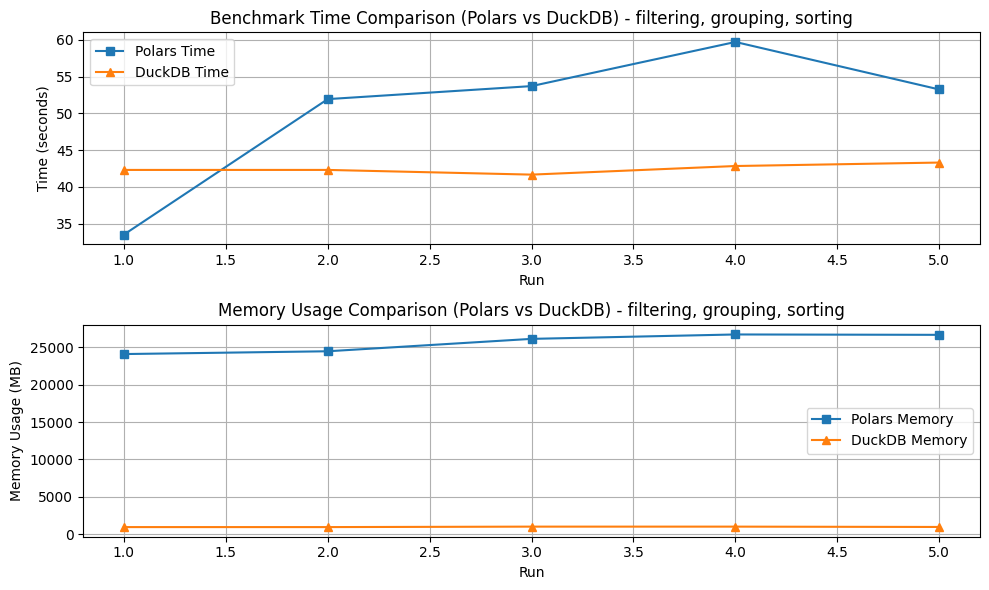

In [14]:
title1 = "Benchmark Time Comparison (Polars vs DuckDB) - filtering, grouping, sorting"
title2 = "Memory Usage Comparison (Polars vs DuckDB) - filtering, grouping, sorting"
plot_results(df_results, title1, title2)